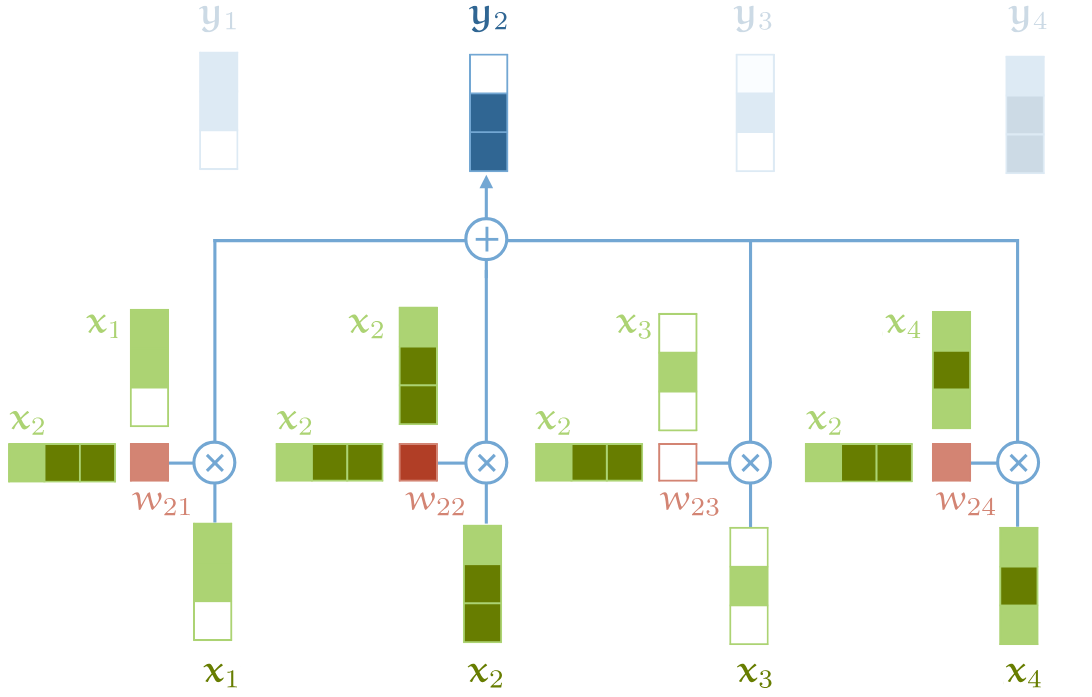

In [11]:
import torch
import torch.nn.functional as F
from torch import nn

In [ ]:
batch_size = 3
sequence_length = 5
feature_dim = 4

X = torch.rand(batch_size, sequence_length, feature_dim)
W = torch.bmm(X, X.transpose(1, 2))
W = F.softmax(W, dim=2)
Y = torch.bmm(W, X)
print(X)
print(W)
print(Y)

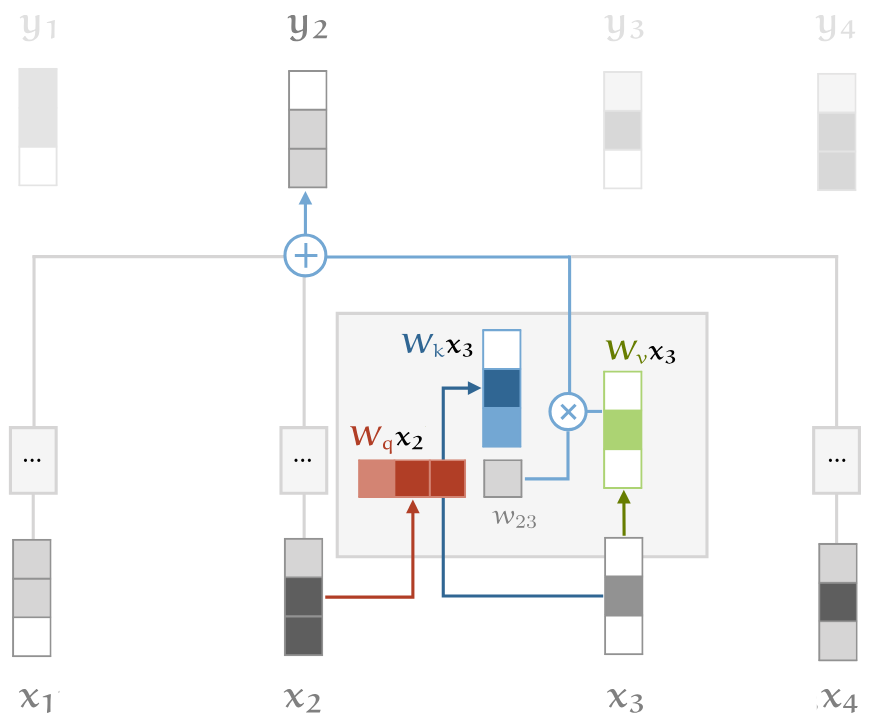

In [ ]:
k = 5
tokeys = nn.Linear(k, k, bias=False)
X = torch.rand(batch_size, sequence_length, feature_dim)
key = tokeys(X)
print(key)

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, k, heads=4, mask=False):
        super().__init__()
        assert k % heads == 0
        self.k = k
        self.heads = heads
        self.toqueries = nn.Linear(k, k, bias=False)
        self.tokeys = nn.Linear(k, k, bias=False)
        self.tovalues = nn.Linear(k, k, bias=False)
        self.unifyheads = nn.Linear(k, k)
        
    def forward(self, X):
        b, t, k = X.shape
        h = self.heads
        queries = self.toqueries(X)
        keys    = self.tokeys(X)   
        values  = self.tovalues(X)
        
        s = k // h # s chunks
        queries = queries.view(b, t, h, s)
        keys    = keys.view(b, t, h, s)
        values  = values.view(b, t, h, s)
        
        # Fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)
        
        # Get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        
        # Scale the dot product
        dot = dot / (k ** (1/2))
        
        # Normalize to distribute attention
        dot = F.softmax(dot, dim=2)
        
        # Apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)
        
        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)
    
        return self.unifyheads(out)
    
class TransformerBlock(nn.Module):
    def __init__(self, k, heads):
        super().__init__()

        self.attention = SelfAttention(k, heads=heads)

        self.norm1 = nn.LayerNorm(k)
        self.norm2 = nn.LayerNorm(k)

        self.ff = nn.Sequential(
            nn.Linear(k, 4 * k),
            nn.ReLU(),
            nn.Linear(4 * k, k)
        )

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(attended + x)

        fedforward = self.ff(x)
        return self.norm2(fedforward + x)
    
    
class Transformer(nn.Module):
    def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
        super().__init__()

        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, k)
        self.pos_emb = nn.Embedding(seq_length, k)

		# The sequence of transformer blocks that does all the
		# heavy lifting
        tblocks = []
        for i in range(depth):
            tblocks.append(TransformerBlock(k=k, heads=heads))
        self.tblocks = nn.Sequential(*tblocks)

		# Maps the final output sequence to class logits
        self.toprobs = nn.Linear(k, num_classes)

    def forward(self, x):
        """
        :param x: A (b, t) tensor of integer values representing
                  words (in some predetermined vocabulary).
        :return: A (b, c) tensor of log-probabilities over the
                 classes (where c is the nr. of classes).
        """
		# generate token embeddings
        tokens = self.token_emb(x)
        b, t, k = tokens.size()

		# generate position embeddings
	    positions = torch.arange(t)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)

        x = tokens + positions
        x = self.tblocks(x)

        # Average-pool over the t dimension and project to class
        # probabilities
        x = self.toprobs(x.mean(dim=1))
        return F.log_softmax(x, dim=1)